In [53]:
import pandas as pd

In [54]:
data = pd.read_csv(
    'teks.csv'
    , header=0 # Menentukan baris pertama digunakan sebagai nama kolom
)

# 1. Distribusi Kelas

In [55]:
jumlah_label = data['label'].value_counts() # Menjumlahkan nilai tiao label
jumlah_label

label
0    440
1    424
Name: count, dtype: int64

In [56]:
import matplotlib.pyplot as plt

# 2. Analisis Panjang Teks

In [57]:
# Menghitung panjang teks dalam karakter dan menambahkan kolom baru ke data
data['panjang_teks'] = data['teks'].str.len()

In [58]:
# Statistik deskripsi panjang teks
print(data['panjang_teks'].describe())

# Rata-rata panjang teks berdasarkan 'label'
print(data.groupby('label')['panjang_teks'].mean())

count     864.000000
mean      432.375000
std       556.940979
min         4.000000
25%       116.750000
50%       304.000000
75%       482.250000
max      7048.000000
Name: panjang_teks, dtype: float64
label
0    285.945455
1    584.330189
Name: panjang_teks, dtype: float64


In [59]:
import numpy as np

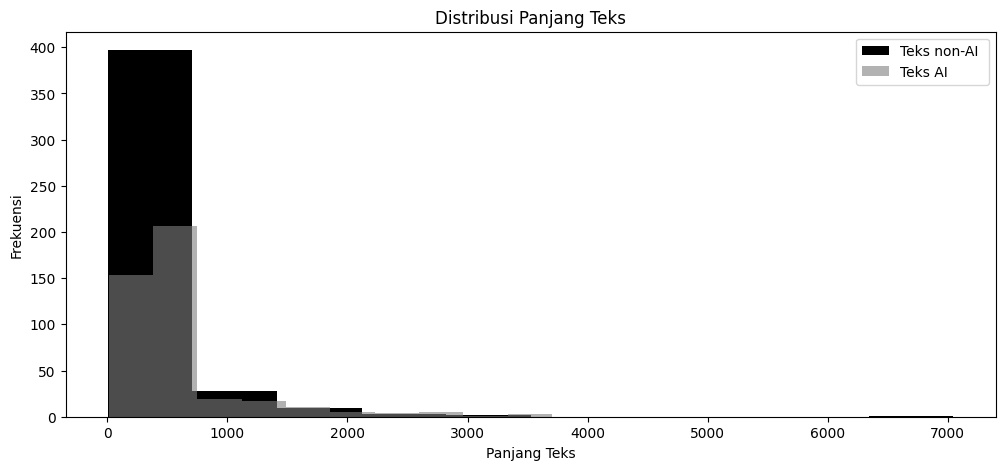

In [60]:
# Membuat histogram
plt.figure(figsize=(12, 5))
plt.hist( 
    data[data['label'] == 0]['panjang_teks'] # Hanya memilih panjang teks dari baris label = 0
    , label='Teks non-AI '
    , color='black'
)
plt.hist(
    data[data['label'] == 1]['panjang_teks'] # Hanya memilih panjang teks dari baris label = 1
    , alpha=0.6
    , label='Teks AI'
    , color='grey'
)
# Menyesuaikan judul
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Teks')
plt.legend()
plt.show()


# 3. Analisis Stopword dan POS-Tag

## 1. POS TAGGING

In [61]:
import stanza
from collections import defaultdict, Counter


stanza.download('id')
nlp = stanza.Pipeline(
    lang='id'
    , processors='tokenize,pos'
)

2025-06-17 19:13:28 INFO: Downloaded file to C:\Users\HP\stanza_resources\resources.json
2025-06-17 19:13:28 INFO: Downloading default packages for language: id (Indonesian) ...
2025-06-17 19:13:30 INFO: File exists: C:\Users\HP\stanza_resources\id\default.zip
2025-06-17 19:13:36 INFO: Finished downloading models and saved to C:\Users\HP\stanza_resources
2025-06-17 19:13:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-06-17 19:13:38 INFO: Downloaded file to C:\Users\HP\stanza_resources\resources.json
2025-06-17 19:13:38 WARNING: Language id package default expects mwt, which has been added
2025-06-17 19:13:38 INFO: Loading these models for language: id (Indonesian):
| Processor | Package    |
--------------------------
| tokenize  | gsd        |
| mwt       | gsd        |
| pos       | gsd_charlm |

2025-06-17 19:13:38 INFO: Using dev

In [62]:
# Hitung frekuensi POS tag
jumlah_pos_ai = Counter()
jumlah_pos_nonai = Counter()

for _, row in data.iterrows():
    doc = nlp(row['teks'])
    tags = [word.upos for sent in doc.sentences for word in sent.words]
    
    if row['label'] == 1:
        jumlah_pos_ai.update(tags)
    else:
        jumlah_pos_nonai.update(tags)

# Gabungkan semua POS tag yang muncul
all_tags = set(jumlah_pos_ai) | set(jumlah_pos_nonai)
data_pos_freq = pd.DataFrame({
    'POS_Tag': list(all_tags)
    , 'AI': [jumlah_pos_ai.get(tag, 0) for tag in all_tags]
    , 'NonAI': [jumlah_pos_nonai.get(tag, 0) for tag in all_tags]
    , 'Selisih': [jumlah_pos_ai.get(tag, 0) - jumlah_pos_nonai.get(tag, 0) for tag in all_tags]
    , 'Total': [jumlah_pos_ai.get(tag, 0) + jumlah_pos_nonai.get(tag, 0) for tag in all_tags]
})

## 2. STOPWORD

In [63]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [64]:
# Unduh stopwords dan tokenizer
nltk.download('punkt')
nltk.download('stopwords')

# Ambil stopword Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# Tokenisasi dan hitung frekuensi stopword
jumlah_stopword_ai = Counter()
jumlah_stopword_nonai = Counter()

for _, row in data.iterrows():
    tokens = word_tokenize(row['teks'].lower())
    stopword_tokens = [t for t in tokens if t in stop_words]

    if row['label'] == 1:
        jumlah_stopword_ai.update(stopword_tokens)
    else:
        jumlah_stopword_nonai.update(stopword_tokens)

# Gabungkan semua stopword yang muncul
all_stopwords = set(jumlah_stopword_ai) | set(jumlah_stopword_nonai)

# Buat DataFrame
data_stopword = pd.DataFrame({
    'Stopword': list(all_stopwords),
    'AI': [jumlah_stopword_ai.get(sw, 0) for sw in all_stopwords],
    'NonAI': [jumlah_stopword_nonai.get(sw, 0) for sw in all_stopwords]
})

# Hitung Selisih dan Total
data_stopword['Selisih'] = data_stopword['AI'] - data_stopword['NonAI']
data_stopword['Total'] = data_stopword['AI'] + data_stopword['NonAI']


## Visualisasi

In [66]:
import matplotlib.pyplot as plt
import numpy as np

### 1. POS TAGGING

In [67]:
# Buat DataFrame dari counter

# Sort berdasarkan total frekuensi
data_pos_freq['Total'] = data_pos_freq['AI'] + data_pos_freq['NonAI']
data_pos_freq = data_pos_freq.sort_values(by='Total', ascending=False)

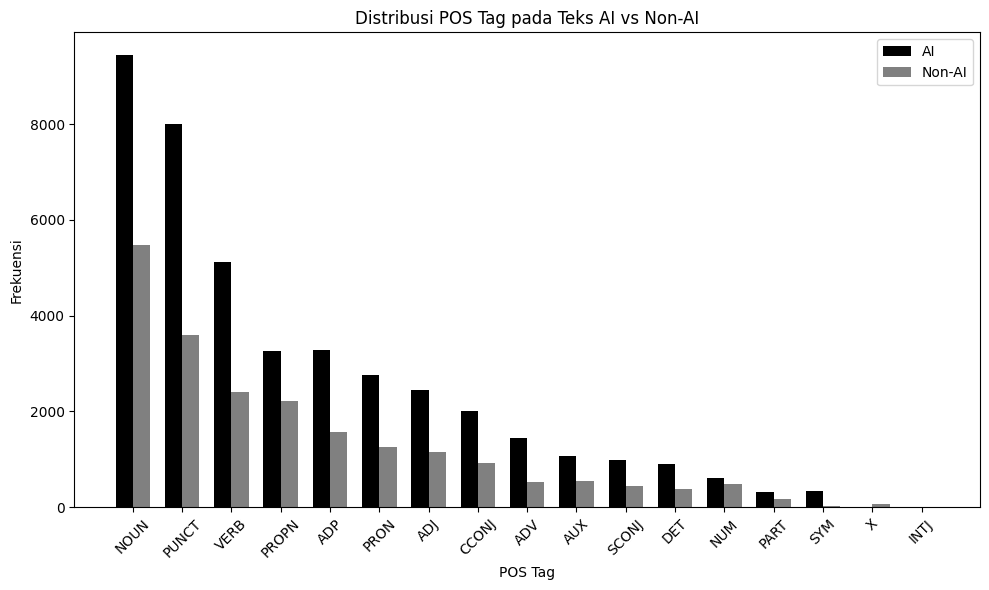

In [68]:
# Visualisasi
x = np.arange(len(data_pos_freq))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, data_pos_freq['AI'], width, label='AI', color='black')
rects2 = ax.bar(x + width/2, data_pos_freq['NonAI'], width, label='Non-AI', color='gray')

# Tambahan kosmetik
ax.set_xlabel('POS Tag')
ax.set_ylabel('Frekuensi')
ax.set_title('Distribusi POS Tag pada Teks AI vs Non-AI')
ax.set_xticks(x)
ax.set_xticklabels(data_pos_freq['POS_Tag'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

### 2. STOPWORD

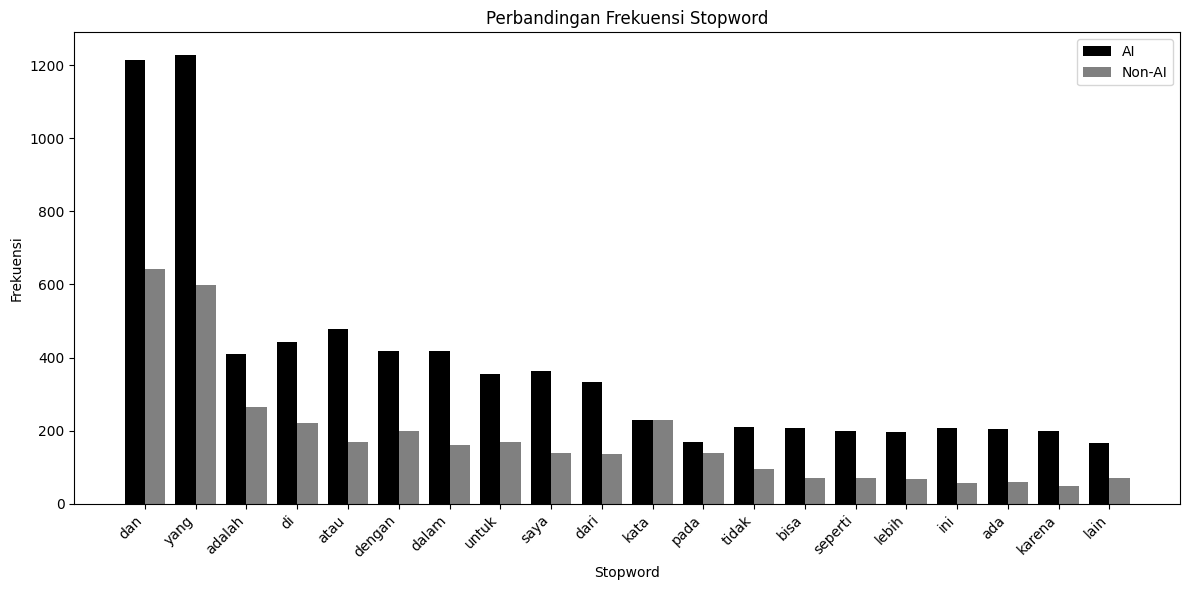

In [69]:
import matplotlib.pyplot as plt

# Ambil 20 stopword dengan frekuensi total tertinggi
top_stopwords = data_stopword.sort_values('Total', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(top_stopwords))

plt.bar([i - bar_width/2 for i in x], top_stopwords['AI'], width=bar_width, label='AI', color='black')
plt.bar([i + bar_width/2 for i in x], top_stopwords['NonAI'], width=bar_width, label='Non-AI', color='gray')

plt.xticks(ticks=x, labels=top_stopwords['Stopword'], rotation=45, ha='right')
plt.xlabel('Stopword')
plt.ylabel('Frekuensi')
plt.title('Perbandingan Frekuensi Stopword')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Mengetahui Permasalahan Data

## a. Missing Value

In [70]:
missing = data.isnull().sum()
print("\nMissing values:")
print(missing)


Missing values:
teks            0
label           0
panjang_teks    0
dtype: int64


## b. Data Noise

In [71]:
import re

In [72]:
def is_noise(teks): 
    return bool( # Mengembalikan nilai True jika teks dianggap noise (bukan kata), dan False jika teks mengandung huruf
        re.fullmatch( # Mencocokkan seluruh teks dengan pola r'[^a-zA-Z]+'
            r'[^a-zA-Z]+' # Menemukan karakter yang bukan huruf
            , teks
        )
    )

# Menyimpan kolom baru 'is_noise' dan menerapkan ke semua baris teks
data['is_noise'] = data['teks'].apply(is_noise)

# Menghitung jumlah noise
jumlah_noise = data['is_noise'].sum()
jumlah_noise

0

## c. Duplikat Data

In [73]:
# Menghitung jumlah teks duplikat
# Menemukan duplikat berdasarkan kolom 'teks'
duplikat = data[
    data.duplicated(
        subset=['teks']
        , keep=False
    )
]
jumlah_duplikat = len(duplikat)
jumlah_duplikat

42

## d. Outlier

In [74]:
# Mendeteksi outlier berdasarkan panjang teks (Menggunakan IQR)
Q1 = data['panjang_teks'].quantile(0.25)
Q3 = data['panjang_teks'].quantile(0.75)
IQR = Q3 - Q1
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

data['is_outlier'] = (
    data['panjang_teks'] < batas_bawah
) | (
    data['panjang_teks'] > batas_atas
)

# Jumlah teks Outlier
jumlah_outlier = data['is_outlier'].sum()
jumlah_outlier

77

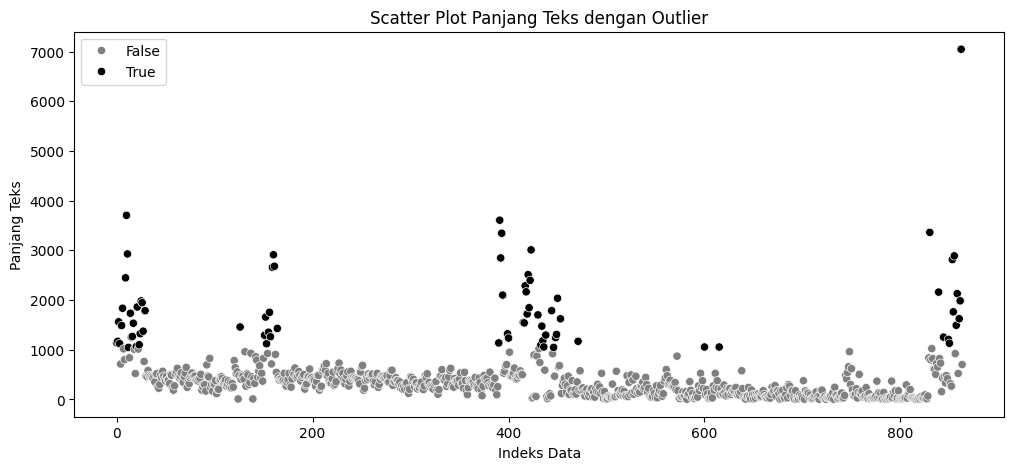

In [75]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.scatterplot(
    x=range(len(data)) # Sumbu x adalah indeks data
    , y=data['panjang_teks']
    , hue=data['is_outlier']
    , palette={
        True: 'black' # Outlier berwarna merah
        , False: 'grey'
    }
)
plt.legend()
plt.title("Scatter Plot Panjang Teks dengan Outlier")
plt.xlabel("Indeks Data")
plt.ylabel("Panjang Teks")
plt.show()

In [76]:
# Menyimpan Data Outlier Terpisah
outliers = data[data['is_outlier'] == True]
outliers.to_csv(
    'is_outlier.csv'
    , index=False
)

In [77]:
# Menampilkan hasil
data.to_csv('hasil_eda.csv', index=False)

In [78]:
batas_bawah, batas_atas

(-431.5, 1030.5)